In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from motion_models import MM_CTRV, MM_CA
from simulation import *
from scenarios import get_scenario

T = 0.05  # time between cycles
dim_state = 5 # dimension of state
dim_meas = 3 # dimension of measurements
std_doppler = 0.5
std_r, std_phi = 0.5, np.radians(2)

sc_id = '4'
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
frame_vec = np.arange(n_frames)  
SEED = 0
np.random.seed(SEED)

# truth motion
q_vec = [0.1**2/T, 0.1**2/T]
m_ctrv = MM_CTRV(0, 0)
# q_vec = [0*T, 0*T]
sim_state = simulate_motion_CTRV(T, n_frames, sc['x_init'], m_ctrv, sc['manx_frames'])
meas_pol = simulate_measurements_polar(sim_state, std_r, std_phi, std_doppler)
# meas_cart = simulate_measurements_cartesian(sim_state, std_x, std_y, std_doppler)

# # scenario viewer
# plot_options = [
#     {'grid_pos': (0, 1), 'index': IX, 'ylabel': 'X (m)', 'meas_index': IMX},
#     {'grid_pos': (0, 2), 'index': IY, 'ylabel': 'Y (m)', 'meas_index': IMY},
#     {'grid_pos': (1, 1), 'index': IPHI, 'ylabel': 'Heading (deg)', 'fn': np.degrees},
#     {'grid_pos': (1, 2), 'index': IV, 'ylabel': 'Velocity (m/s)'},
#     {'grid_pos': (2, 1), 'index': IW, 'ylabel': 'Turn rate (deg)', 'fn': np.degrees},
# ]
# fig = plt.figure(figsize=(16, 8))
# gs = fig.add_gridspec(3, 3)
# # X-Y plot
# ax1 = fig.add_subplot(gs[:, 0])
# ax1.plot(meas_pol[IMX, :], meas_pol[IMY], '.', label='meas pol')
# ax1.plot(sim_state[IX, :], sim_state[IY, :], 'k--', label='truth')
# ax1.legend()
# ax1.grid()
# ax1.set_xlabel('Pos. X (m)')
# ax1.set_ylabel('Pos. Y (m)')
# time_vec = frame_vec*T
# for p in plot_options:
#     ax = fig.add_subplot(gs[*p['grid_pos']])
#     if p.get('fn', False):
#         sim_state[p['index'], :] = p['fn'](sim_state[p['index'], :])
#     if p.get('meas_index', False):
#         ax.plot(time_vec, meas_pol[p['meas_index'], :], '.', label='meas')
#     ax.plot(time_vec, sim_state[p['index'], :], 'k-', label='truth')
#     ax.set_ylabel(p['ylabel'])
#     ax.grid()

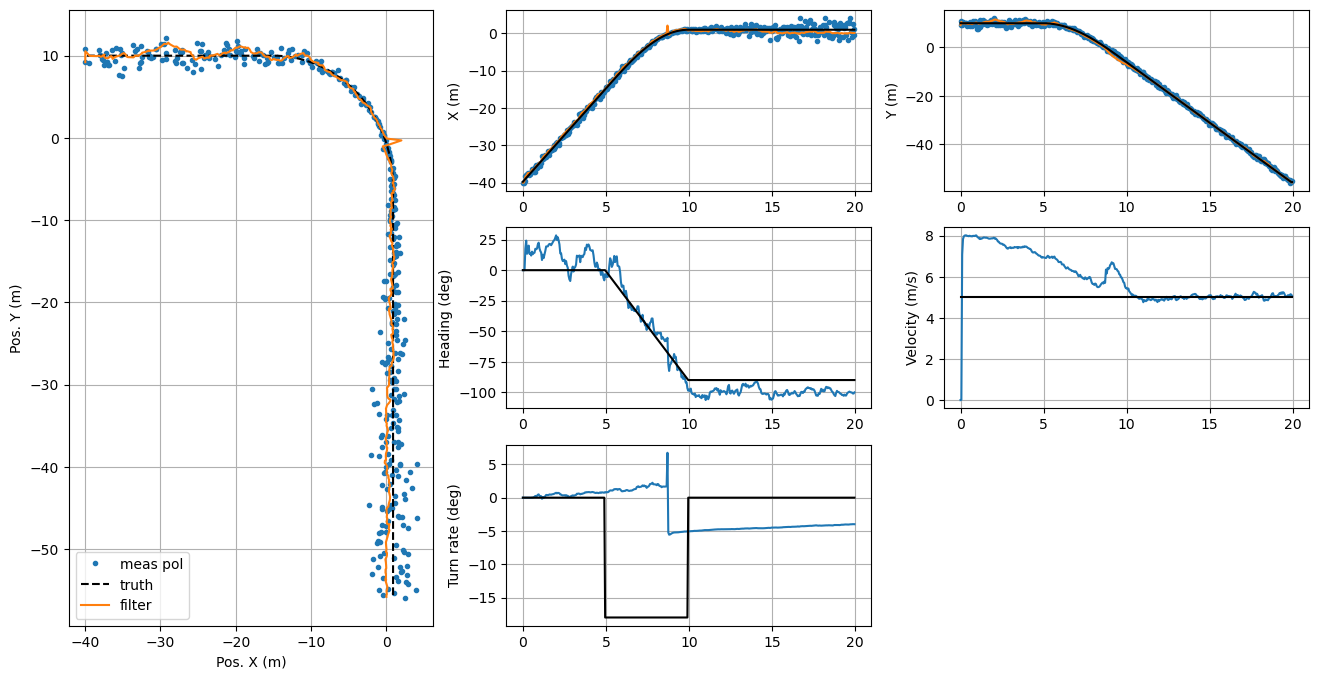

In [7]:
from filters import EKF_CTRV, UKF_CTRV
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

def fx_ctrv(x: np.ndarray, T: float):
    w = x[IW]
    if np.abs(w) > np.radians(0.5):
        phi_p = x[IPHI] + w*T
        rc = x[IV]/w
        x[IX] += rc * (np.sin(phi_p) - np.sin(x[IPHI])) 
        x[IY] += rc * (-np.cos(phi_p) + np.cos(x[IPHI]))
        x[IPHI] = phi_p 
    else:
        x[IX] += x[IV]*np.cos(x[IPHI]) * T
        x[IY] += x[IV]*np.sin(x[IPHI]) * T
    return x

def hx_pos_only(x):
    x, y = x[IX], x[IY]
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.array([r, phi])

def get_process_noise_matrix(x:np.ndarray, var_v, var_w, T: float):
    q = np.diag([var_v, var_w])
    phi = x[IPHI]
    gamma = np.array([
        [0.5*np.cos(phi)*T**2, 0],
        [0.5*np.sin(phi)*T**2, 0],
        [0, 0.5*T**2],
        [T, 0],
        [0, T],
    ])
    Q = gamma @ q @ gamma.T
    return Q


var_v = 3**2
var_w = np.radians(10)**2
# kf = EKF_CTRV(T, var_v, var_w, std_r, std_phi)

kf = UKF_CTRV(T, var_v, var_w, std_r, std_phi)

# testing UKF from filterpy
points = MerweScaledSigmaPoints(n=5, alpha=.1, beta=2., kappa=-2)
kf2 = UnscentedKalmanFilter(dim_x=5, dim_z=2, dt=T, fx=fx_ctrv, hx=hx_pos_only, points=points)
kf2.R = np.diag([std_r**2, std_phi**2])

X = np.zeros((5, n_frames))
for frame in frame_vec:
    meas = np.array([meas_pol[IMR, frame], meas_pol[IMPHI, frame]])
    if frame == 0:
        z0 = np.array([meas[0] * np.cos(meas[1]), meas[0] * np.sin(meas[1])])
        kf.initializeFilter(z0)

        kf2.x[IX] = z0[IX]
        kf2.x[IY] = z0[IY]
        kf2.P = np.diag([3**2, 3**2, np.radians(90)**2, 20**2, np.radians(10)**2])
    else:
        kf.predict()
        kf2.Q = get_process_noise_matrix(kf.x, var_v, var_w, T)
        kf2.predict()
        
        kf.update(meas)
        kf2.update(meas)
    X[:, frame] = kf.x


plot_options = [
    {'grid_pos': (0, 1), 'index': IX, 'ylabel': 'X (m)', 'meas_index': IMX},
    {'grid_pos': (0, 2), 'index': IY, 'ylabel': 'Y (m)', 'meas_index': IMY},
    {'grid_pos': (1, 1), 'index': IPHI, 'ylabel': 'Heading (deg)', 'fn': np.degrees},
    {'grid_pos': (1, 2), 'index': IV, 'ylabel': 'Velocity (m/s)'},
    {'grid_pos': (2, 1), 'index': IW, 'ylabel': 'Turn rate (deg)', 'fn': np.degrees},
]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 3)
# X-Y plot
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(meas_pol[IMX, :], meas_pol[IMY], '.', label='meas pol')
ax1.plot(sim_state[IX, :], sim_state[IY, :], 'k--', label='truth')
ax1.plot(X[IX, :], X[IY, :], '-', label='filter')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Pos. X (m)')
ax1.set_ylabel('Pos. Y (m)')
time_vec = frame_vec*T
for p in plot_options:
    ax = fig.add_subplot(gs[*p['grid_pos']])

    sim_var = sim_state[p['index']]
    filter_var = X[p['index']]
    if p.get('fn', False):
        sim_var = p['fn'](sim_var)
        filter_var = p['fn'](filter_var)

    if p.get('meas_index', False):
        ax.plot(time_vec, meas_pol[p['meas_index'], :], '.', label='meas')
    ax.plot(time_vec, filter_var, '-', label='filter')
    ax.plot(time_vec, sim_var, 'k-', label='truth')
    ax.set_ylabel(p['ylabel'])
    ax.grid()

In [3]:
kf.x

array([ 3.41473982e-02, -5.57997509e+01, -1.74725513e+00,  5.06623794e+00,
       -6.95922037e-02])

In [4]:
kf2.x

array([ 9.69831566e-01, -5.58638502e+01, -1.54138219e+00,  4.93142020e+00,
        2.84432822e-02])